In [2]:
import time
import wave
import librosa
import librosa.display
import librosa.util
import librosa.filters
import librosa.display
from librosa.core import audio

import soundfile as sf
import soundfile

from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os

from pydub import AudioSegment

import scipy
from scipy.io.wavfile import write
from scipy import signal
from scipy.signal import butter, lfilter, filtfilt
from scipy.io import wavfile
from scipy.signal import fftconvolve

import random

import subprocess

import colorednoise as cn

import torch
import torchaudio

In [3]:

def RIR_Filtering(input_audio, output_audio, impulse_response_txt):

    # Read audio file
    sample_rate, audio_data = wavfile.read(input_audio)

    # Read impulse response samples from text file
    with open(impulse_response_txt, 'r') as f:
        impulse_response = np.array([float(line.strip()) for line in f.readlines()])

    # Apply convolution
    convolved_audio = fftconvolve(audio_data, impulse_response)#, mode='same')

    # Normalize the convolved audio
    convolved_audio = (convolved_audio / np.max(np.abs(convolved_audio)) * np.iinfo(np.int16).max).astype(np.int16)

    # Save the convolved audio to output file
    wavfile.write(output_audio, sample_rate, convolved_audio)

# Example usage:
RIR_Filtering('upc_ca_ona_100000.wav', 'upc_ca_ona_100000RIR.wav', '../program_samples/AIR_Database/air_binaural_aula_carolina_0_1_1_90_3.txt')



In [ ]:
import torchaudio
import torchaudio.functional as F

def resample_audio(input_filename, target_sample_rate):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # Load the audio file
    waveform, sample_rate = torchaudio.load(input_filename)
    waveform = waveform.to(device)
    # Create a resample transform
    resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=target_sample_rate)

    # Apply the resample transform to the waveform
    resampled_waveform = resampler(waveform)

    return resampled_waveform, target_sample_rate


def RIR_Filtering(input_filename, output_filename, rir_filepath):
    # Load the audio and the RIR files
    waveform, sample_rate = torchaudio.load(input_filename)
    rir_raw, rir_sample_rate = torchaudio.load(rir_filepath)

    rir = rir_raw[:, int(sample_rate * 1.01) : int(sample_rate * 1.3)]
    rir = rir / torch.linalg.vector_norm(rir, ord=2)


    # If the RIR file has a different sample rate, resample it
    if rir_sample_rate != sample_rate:
        rir_waveform, _ = resample_audio(rir_filepath, sample_rate)

    # Apply the RIR to the audio file
    #augmented_waveform = torch.nn.functional.conv1d(waveform[None, :], rir_waveform[None, :])[0]

    augmented_waveform = F.fftconvolve(waveform[None, :], rir_waveform[None, :])
    # Save the augmented audio to the output file
    torchaudio.save(output_filename, augmented_waveform, sample_rate)


RIR_Filtering('upc_ca_ona_100000.wav', 'upc_ca_ona_100000RIR.wav', '../program_samples/AIR_Database/air_binaural_aula_carolina_0_1_1_90_3.txt')



In [4]:
def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
    figure.suptitle(title)

def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
    waveform = waveform.numpy()

    num_channels, _ = waveform.shape

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
    figure.suptitle(title)

In [12]:
import torchaudio.functional as F

input_filename = "upc_ca_ona_100000.wav"
rir_filepath = "../program_samples/real_rirs_isotropic_noises/air_type1_air_binaural_lecture_1_6.wav"
output_filename = "upc_ca_ona_100000RIR.wav"

waveform, sample_rate = torchaudio.load(input_filename)
#plot_waveform(waveform, sample_rate, title="Original")
#plot_specgram(waveform, sample_rate, title="Original")



rir_raw, rir_sample_rate = torchaudio.load(rir_filepath)
#plot_waveform(rir_raw, sample_rate, title="Room Impulse Response (raw)")
#plot_specgram(rir_raw, sample_rate, title="Room Impulse Response (raw)")

rir = rir_raw[:, int(sample_rate * 1.01) : int(sample_rate * 1.3)]
rir = rir / torch.linalg.vector_norm(rir, ord=2)

#plot_waveform(rir, sample_rate, title="Room Impulse Response fixed")
#plot_specgram(rir, sample_rate, title="Room Impulse Response fixed")

# If the RIR file has a different sample rate, resample it
if rir_sample_rate != sample_rate:
    rir , _ = resample_audio(rir_filepath, sample_rate)
    #plot_waveform(rir, sample_rate, title="Room Impulse Response sampled")
    #plot_specgram(rir, sample_rate, title="Room Impulse Response sampled")


# Apply the RIR to the audio file
#augmented_waveform = torch.nn.functional.conv1d(waveform[None, :], rir_waveform[None, :])[0]

augmented_waveform = F.fftconvolve(waveform, rir)

#plot_waveform(augmented_waveform, sample_rate, title="Augmented")
#plot_specgram(augmented_waveform, sample_rate, title="Augmented")
# Save the augmented audio to the output file
torchaudio.save(output_filename, augmented_waveform, sample_rate)

In [7]:
torch.cuda.is_available()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


16000
48000
48000


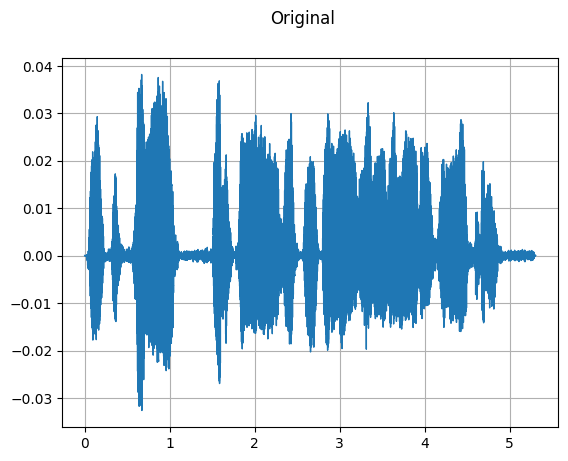

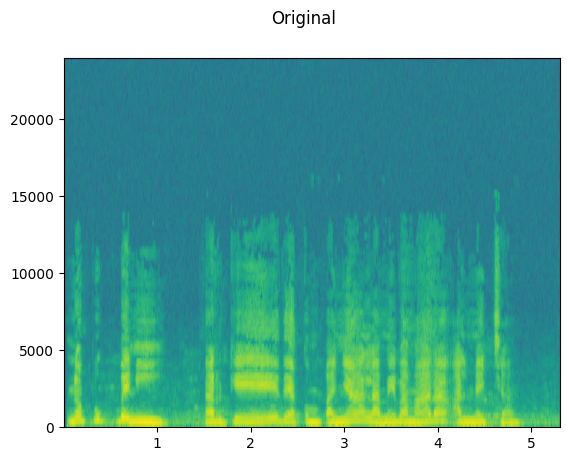

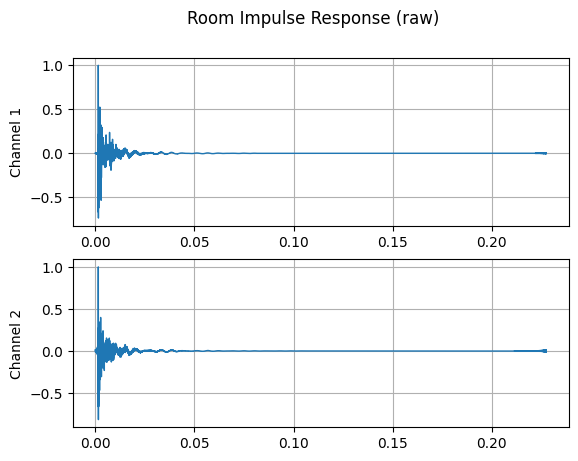

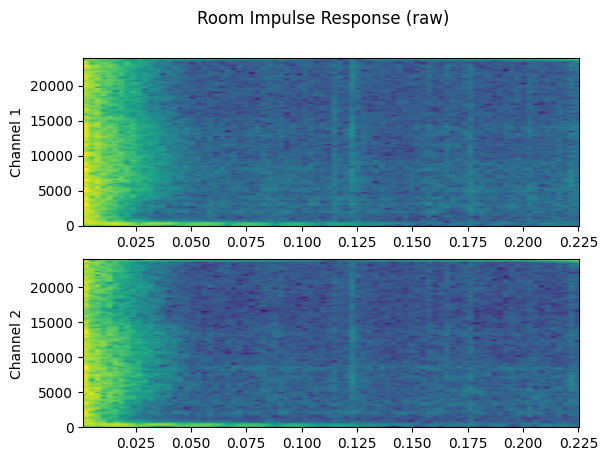

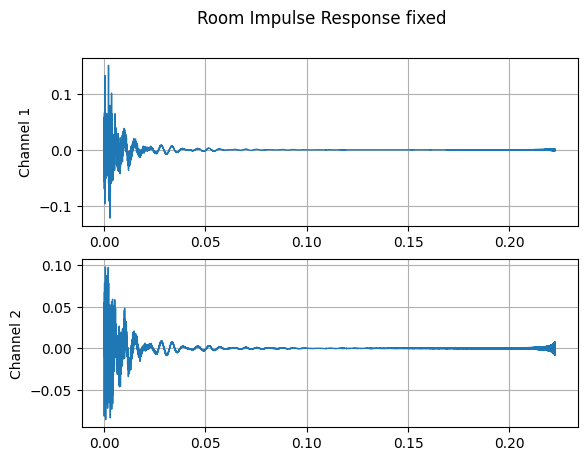

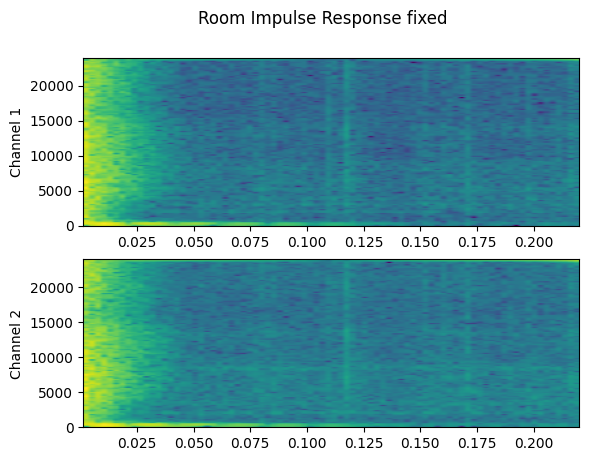

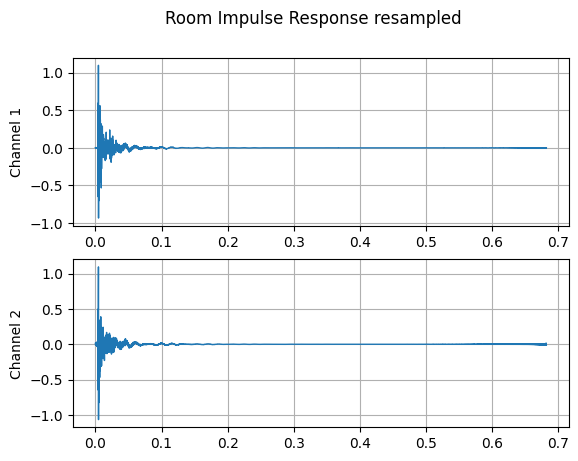

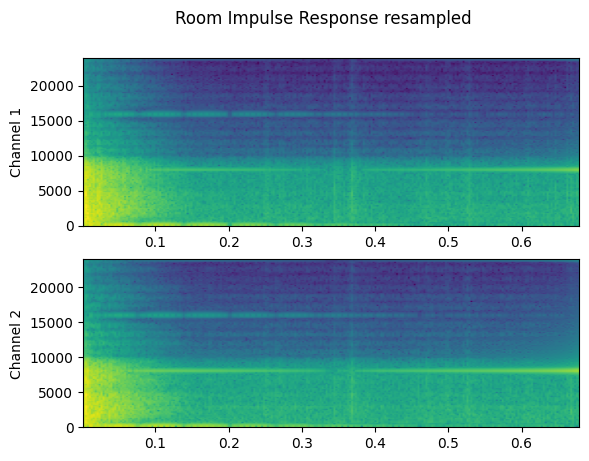

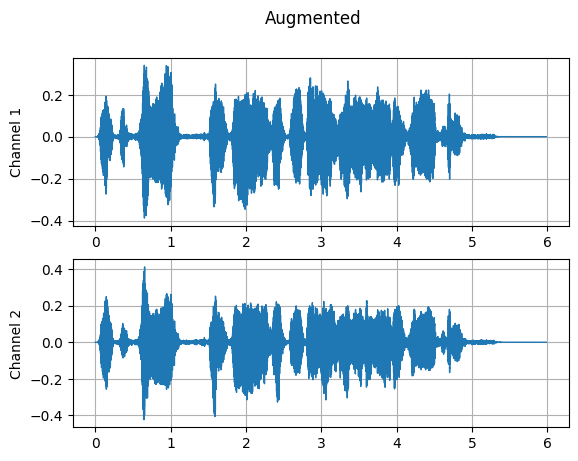

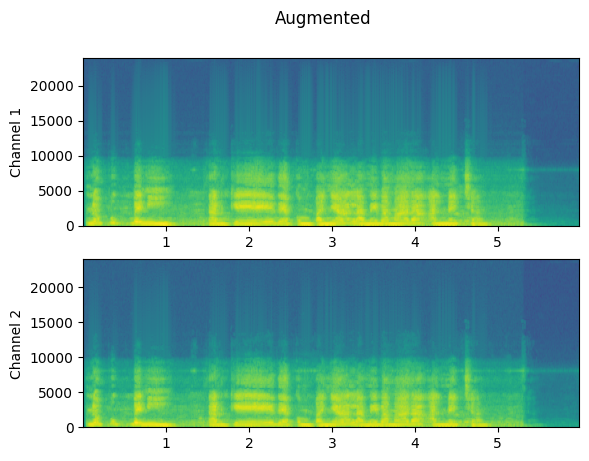

In [47]:
import torchaudio.functional as F
import torchaudio
# Check if CUDA is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_filename = "../DATABASE/lt400/common_voice_ca_17852479.wav"
rir_filepath = "../program_samples/real_rirs_isotropic_noises/air_type1_air_binaural_booth_1_3.wav"
output_filename = "upc_ca_ona_100000RIR.wav"

waveform, sample_rate = torchaudio.load(input_filename)
waveform = waveform.to(device)  # Move the waveform tensor to the GPU
plot_waveform(waveform.cpu(), sample_rate, title="Original")  # Move the tensor back to the CPU for plotting
plot_specgram(waveform.cpu(), sample_rate, title="Original")

rir_raw, rir_sample_rate = torchaudio.load(rir_filepath)

rir_raw = rir_raw.to(device)  # Move the RIR tensor to the GPU

plot_waveform(rir_raw.cpu(), sample_rate, title="Room Impulse Response (raw)")
plot_specgram(rir_raw.cpu(), sample_rate, title="Room Impulse Response (raw)")

rir = rir_raw[:, int(sample_rate * 0.005) : int(sample_rate * 0.25)]
rir = rir / torch.linalg.vector_norm(rir, ord=2)

plot_waveform(rir.cpu(), sample_rate, title="Room Impulse Response fixed")
plot_specgram(rir.cpu(), sample_rate, title="Room Impulse Response fixed")

# If the RIR file has a different sample rate, resample it
print(rir_sample_rate)
print(sample_rate)
if rir_sample_rate != sample_rate:
    rir , resample_rate = resample_audio(rir_filepath, sample_rate)
    print(resample_rate)
    rir = rir.to(device)  # Move the resampled RIR tensor to the GPU
    plot_waveform(rir.cpu(), sample_rate, title="Room Impulse Response resampled")
    plot_specgram(rir.cpu(), sample_rate, title="Room Impulse Response resampled")

# Apply the RIR to the audio file
augmented_waveform = F.fftconvolve(waveform, rir)

plot_waveform(augmented_waveform.cpu(), sample_rate, title="Augmented")
plot_specgram(augmented_waveform.cpu(), sample_rate, title="Augmented")

# Save the augmented audio to the output file
torchaudio.save(output_filename, augmented_waveform.cpu(), sample_rate)  # Move the tensor back to the CPU for saving


In [1]:
import torchaudio.functional as F
import torchaudio

def resample_audio(input_filename, target_sample_rate):
    # Load the audio file
    waveform, sample_rate = torchaudio.load(input_filename)

    # Create a resample transform
    resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=target_sample_rate)

    # Apply the resample transform to the waveform
    resampled_waveform = resampler(waveform)

    return resampled_waveform, target_sample_rate


def RIR_Filtering(input_filename, output_filename, rir_filepath):
    device = torch.device("cpu")#"cuda" if torch.cuda.is_available() else "cpu")

    waveform, sample_rate = torchaudio.load(input_filename)
    waveform = waveform.to(device)  # Move the waveform tensor to the GPU

    rir_raw, rir_sample_rate = torchaudio.load(rir_filepath)

    rir_raw = rir_raw.to(device)  # Move the RIR tensor to the GPU

    #Fix and normalize raw rir vector
    rir = rir_raw[:, int(sample_rate * 0.005) : int(sample_rate * 0.25)]
    rir = rir / torch.linalg.vector_norm(rir, ord=2)

    # If the RIR file has a different sample rate, resample it
    if rir_sample_rate != sample_rate:
        rir , _ = resample_audio(rir_filepath, sample_rate)
        rir = rir.to(device)  # Move the resampled RIR tensor to the GPU

    # Apply the RIR to the audio file
    augmented_waveform = F.fftconvolve(waveform, rir)
    #print("RIR FILTERING COMPLETED WITH FILE: " + str(rir_filepath)+ "TO FILE: " + str(output_filename)
    # Save the resulting noisy signal to a new audio file
    # Save the augmented audio to the output file
    torchaudio.save(output_filename, augmented_waveform.cpu(), sample_rate)  # Move the tensor back to the CPU for saving


In [2]:
import os
import glob
import random
import torch

input_folder = 'lt400'
output_folder = 'output_folder'
rir_folder = "../program_samples/real_rirs_isotropic_noises/"

if not os.path.exists(output_folder):
    os.makedirs(output_folder)


audio_files = [f for f in os.listdir(rir_folder) if f.endswith('.wav')]

# Check if you have at least 20 rirfiles, if not, use the length of the list
# to avoid IndexError.
num_files_to_select = min(3, len(audio_files))

# Select 20 random rirfiles from the list
selected_files = random.sample(audio_files, num_files_to_select)

for rir_files in selected_files:
    print("RIR FILE: " + str(rir_files))
    output_folder = os.path.join(output_folder, f'shift{rir_files}')
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for file in glob.glob(os.path.join(input_folder, '*.wav')):
        output_filename = os.path.join(output_folder, os.path.basename(file))
        rir_files_path = os.path.join(rir_folder, rir_files)
        RIR_Filtering(file, output_filename, rir_files_path )



RIR FILE: air_type1_air_binaural_meeting_1_4.wav
RIR FILE: air_type1_air_binaural_office_0_3.wav
RIR FILE: air_type1_air_phone_meeting_hfrp.wav
